<a href="https://colab.research.google.com/github/elangbijak4/Adaptive-Stratified-Sampling---ASS/blob/main/Perbedaan_PCA_vs_TabNet_Filosofi_dan_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEKILAS PERBANDINGAN DENGAN PCA
PCA memilih fitur untuk konteks secara global, jadi tampak linier, sekali pilih maka itu berlaku global, tetapi TabNet menyesuaikan per sampel, untuk setiap sampel mungkin memiliki fitur terpilih yang berbeda, sehingga secara global dia memilih fitur secara dinamis, berubah-ubah sesuai sampel, sehingga secara global dia tidak linier.

In [4]:
# Cell 1: Install dependencies (run once)
# If you want to use GPU, set Colab runtime to GPU before running.

# CPU-safe PyTorch install (let pip decide best build)
!pip install -q torch torchvision torchaudio

# Install TabNet from GitHub (recommended for compatibility)
!pip install -q git+https://github.com/dreamquark-ai/tabnet.git

# Utilities
!pip install -q scikit-learn pandas matplotlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Concept primer — what TabNet is (short)

**High-level idea:** TabNet is a deep neural architecture for tabular data that uses *sequential, sparse attention* to decide which features to use at each decision step.  
Key components:

- **Feature Transformer (FT):** a small feed-forward network that transforms selected features into a latent representation.
- **Attentive Transformer (AT):** computes a *mask* (attention) over input features at each decision step, telling the model which features to focus on at that step.
- **Decision Steps (N steps):** at each step the model selects a subset of features via the AT, processes them through FT, and accumulates a partial decision output; final output is aggregated across steps.
- **Sparse masks:** enforced via `sparsemax` (or `entmax`), encouraging the model to use few important features per step — this yields interpretability (feature masks per-step).
- **Why it helps:** adaptive, step-wise feature selection makes the model both powerful and interpretable; it can learn different “views” of the data across steps.


In [9]:
# Cell 3: imports + synthetic dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import random
np.random.seed(0)
random.seed(0)
torch.manual_seed(0)

# Synthetic dataset: 6 features with known linear weights + non-linear noise
n = 6000
X = np.random.normal(0, 1, size=(n, 6))
true_w = np.array([1.2, -0.8, 0.0, 0.5, 0.0, 0.2])  # only some features matter strongly
logit = X.dot(true_w) + 0.3 * np.sin(X[:,0])  # add small non-linearity
probs = 1 / (1 + np.exp(-logit))
y = (probs > 0.5).astype(int)

# Optional: create a "stratum" column to visualize later — not needed for TabNet itself
strata = (X[:,0] > 0).astype(int)  # simple split
df = pd.DataFrame(X, columns=[f"f{i}" for i in range(X.shape[1])])
df["y"] = y
df["stratum"] = strata

train_df, val_df = train_test_split(df, test_size=0.25, stratify=df["y"], random_state=0)
print("train shape:", train_df.shape, "val shape:", val_df.shape)

train shape: (4500, 8) val shape: (1500, 8)


In [10]:
# Cell 4: prepare arrays + set TabNet hyperparameters
feature_cols = [c for c in train_df.columns if c.startswith("f")]
X_train = train_df[feature_cols].values
y_train = train_df["y"].values.astype(int)
X_val = val_df[feature_cols].values
y_val = val_df["y"].values.astype(int)

# TabNet hyperparameters (explain meaning)
# n_d, n_a: width of decision and attention embeddings (controls capacity)
# n_steps: number of decision steps (how many sequential "views" model will create)
# mask_type: 'sparsemax' encourages sparse masks -> interpretability
tabnet_params = dict(
    n_d=8,        # dimension of decision representation
    n_a=8,        # dimension of attention representation
    n_steps=5,    # number of sequential decision steps
    gamma=1.5,    # relaxation parameter (>=1) controls influence of prior steps
    lambda_sparse=1e-3,  # sparsity regularization weight (encourages sparse masks)
    optimizer_params=dict(lr=2e-2),
    mask_type='sparsemax'
)

print("TabNet params:", tabnet_params)

TabNet params: {'n_d': 8, 'n_a': 8, 'n_steps': 5, 'gamma': 1.5, 'lambda_sparse': 0.001, 'optimizer_params': {'lr': 0.02}, 'mask_type': 'sparsemax'}


In [11]:
# Cell 5: instantiate and train TabNet
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

clf = TabNetClassifier(
    n_d=tabnet_params['n_d'],
    n_a=tabnet_params['n_a'],
    n_steps=tabnet_params['n_steps'],
    gamma=tabnet_params['gamma'],
    lambda_sparse=tabnet_params['lambda_sparse'],
    optimizer_params=tabnet_params['optimizer_params'],
    mask_type=tabnet_params['mask_type'],
    device_name=device,
    verbose=1
)

# fit: note TabNet accepts numpy arrays; we pass both train and validation so it can early stop
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_name=['train','valid'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=10,
    batch_size=256,
    virtual_batch_size=64
)

Using device: cuda


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7102  | train_accuracy: 0.854   | valid_accuracy: 0.86533 |  0:00:01s
epoch 1  | loss: 0.31819 | train_accuracy: 0.88911 | valid_accuracy: 0.90067 |  0:00:02s
epoch 2  | loss: 0.22843 | train_accuracy: 0.91867 | valid_accuracy: 0.924   |  0:00:03s
epoch 3  | loss: 0.19889 | train_accuracy: 0.94111 | valid_accuracy: 0.93867 |  0:00:05s
epoch 4  | loss: 0.16232 | train_accuracy: 0.95711 | valid_accuracy: 0.94333 |  0:00:06s
epoch 5  | loss: 0.16408 | train_accuracy: 0.96022 | valid_accuracy: 0.944   |  0:00:07s
epoch 6  | loss: 0.15471 | train_accuracy: 0.95667 | valid_accuracy: 0.94333 |  0:00:08s
epoch 7  | loss: 0.13962 | train_accuracy: 0.96178 | valid_accuracy: 0.95133 |  0:00:10s
epoch 8  | loss: 0.15498 | train_accuracy: 0.93422 | valid_accuracy: 0.92733 |  0:00:11s
epoch 9  | loss: 0.14305 | train_accuracy: 0.95333 | valid_accuracy: 0.94267 |  0:00:12s
epoch 10 | loss: 0.13987 | train_accuracy: 0.96711 | valid_accuracy: 0.95533 |  0:00:13s
epoch 11 | loss: 0.15

/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Accuracy: 0.9806666666666667
F1      : 0.9808074123097287
Precision: 0.9814569536423841
Recall   : 0.9801587301587301

Feature importances (global):
 f0    0.453079
f1    0.294981
f3    0.174057
f2    0.028819
f5    0.027620
f4    0.021443
dtype: float64


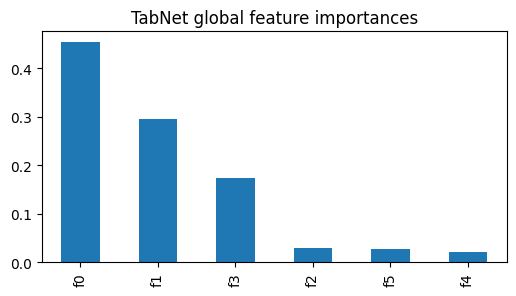

In [12]:
# Cell 6: Evaluate
val_preds = clf.predict(X_val).reshape(-1)
print("Accuracy:", accuracy_score(y_val, val_preds))
print("F1      :", f1_score(y_val, val_preds))
print("Precision:", precision_score(y_val, val_preds))
print("Recall   :", recall_score(y_val, val_preds))

# TabNet global feature importance (sum of masks across steps and samples)
try:
    fi = clf.feature_importances_
    feat_imp = pd.Series(fi, index=feature_cols).sort_values(ascending=False)
    print("\nFeature importances (global):\n", feat_imp)
    # quick bar plot
    plt.figure(figsize=(6,3))
    feat_imp.plot.bar()
    plt.title("TabNet global feature importances")
    plt.show()
except Exception as e:
    print("feature_importances_ not available:", e)

In [13]:
# Cell 7: explain() — per-sample masks
# explain() typically returns (preds, masks) depending on version; masks shape: (n_samples, n_steps, n_features)
explain_output = None
try:
    explain_output = clf.explain(X_val)
    # interpretation of returned structure depends on TabNet version:
    # often explain_output = (feature_importances, masks) or (masks, something)
    # we'll try to detect masks:
    if isinstance(explain_output, tuple) or isinstance(explain_output, list):
        # search for a 3D array in returned tuple/list
        masks = None
        for elt in explain_output:
            if hasattr(elt, 'shape') and len(getattr(elt,'shape')) == 3:
                masks = elt
                break
    elif isinstance(explain_output, dict) and 'masks' in explain_output:
        masks = explain_output['masks']
    else:
        masks = None
    print("Masks type:", type(masks), "shape (if available):", getattr(masks, 'shape', None))
except Exception as e:
    print("explain() failed or returned unexpected format:", e)
    masks = None

Masks type: <class 'NoneType'> shape (if available): None


In [14]:
# Cell 8: visualize masks for first few samples
if masks is None:
    print("No masks available from explain() on this TabNet version. Check clf.feature_importances_.")
else:
    n_samples_to_show = 4
    n_steps = masks.shape[1]
    n_features = masks.shape[2]
    feature_names = feature_cols
    for i in range(n_samples_to_show):
        sample_mask = masks[i]  # shape (n_steps, n_features)
        plt.figure(figsize=(8, 1.6 * n_steps))
        plt.imshow(sample_mask, aspect='auto')
        plt.colorbar(label='mask value')
        plt.yticks(ticks=np.arange(n_steps), labels=[f"step_{s+1}" for s in range(n_steps)])
        plt.xticks(ticks=np.arange(n_features), labels=feature_names, rotation=45)
        plt.title(f"TabNet masks — validation sample {i} (label={y_val[i]})")
        plt.show()

No masks available from explain() on this TabNet version. Check clf.feature_importances_.


In [15]:
# Cell 9: aggregate masks across validation set (mean across samples)
if masks is not None:
    avg_mask = masks.mean(axis=0)  # shape (n_steps, n_features)
    plt.figure(figsize=(8, 1.6 * avg_mask.shape[0]))
    plt.imshow(avg_mask, aspect='auto')
    plt.colorbar(label='avg mask value')
    plt.yticks(ticks=np.arange(avg_mask.shape[0]), labels=[f"step_{s+1}" for s in range(avg_mask.shape[0])])
    plt.xticks(ticks=np.arange(avg_mask.shape[1]), labels=feature_cols, rotation=45)
    plt.title("Average TabNet mask across validation samples (per step)")
    plt.show()
    # Also show sum across steps to see overall attention per feature
    overall_per_feature = avg_mask.sum(axis=0)
    plt.figure(figsize=(6,3))
    pd.Series(overall_per_feature, index=feature_cols).sort_values(ascending=False).plot.bar()
    plt.title("Sum of average masks across steps (feature total attention)")
    plt.show()

In [16]:
# Cell 10: inspect masks vs feature values for a specific sample
if masks is not None:
    idx = 0  # pick sample index from validation set
    print("Feature values for sample", idx)
    for fn, val in zip(feature_cols, X_val[idx]):
        print(f"  {fn}: {val:.3f}")
    print("\nPer-step mask values:")
    df_mask = pd.DataFrame(masks[idx], columns=feature_cols, index=[f"step_{i+1}" for i in range(masks.shape[1])])
    display(df_mask)
else:
    print("Masks not available to inspect.")

Masks not available to inspect.


In [17]:
# Cell 11: ablation: compare sparse vs non-sparse masks
# Re-train a small model with lambda_sparse=0 (no sparsity regularization) for contrast
clf_dense = TabNetClassifier(
    n_d=8, n_a=8, n_steps=5, gamma=tabnet_params['gamma'],
    lambda_sparse=0.0, optimizer_params=tabnet_params['optimizer_params'],
    mask_type='sparsemax', device_name=device, verbose=0
)
clf_dense.fit(X_train, y_train, eval_set=[(X_val,y_val)], eval_name=['valid'], eval_metric=['accuracy'],
              max_epochs=50, patience=5, batch_size=256, virtual_batch_size=64)

# try explain
try:
    explain_dense = clf_dense.explain(X_val)
    masks_dense = None
    if isinstance(explain_dense, tuple) or isinstance(explain_dense, list):
        for elt in explain_dense:
            if hasattr(elt, 'shape') and len(getattr(elt,'shape'))==3:
                masks_dense = elt
                break
except Exception as e:
    masks_dense = None
    print("explain failed for dense model:", e)

# Compare avg sparsity (proportion of near-zero entries) if both masks exist
if masks is not None and masks_dense is not None:
    avg_mask_sparse = masks.mean()
    avg_mask_dense = masks_dense.mean()
    # compute proportion of small entries
    prop_zero_sparse = (np.abs(masks) < 1e-3).mean()
    prop_zero_dense = (np.abs(masks_dense) < 1e-3).mean()
    print("Proportion tiny-mask entries (sparse model):", prop_zero_sparse)
    print("Proportion tiny-mask entries (dense model):", prop_zero_dense)
    # Visualize avg masks side by side for comparison (first step)
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.imshow(masks.mean(axis=0), aspect='auto'); plt.title('avg masks (sparse lambda>0)')
    plt.subplot(1,2,2)
    plt.imshow(masks_dense.mean(axis=0), aspect='auto'); plt.title('avg masks (lambda=0)')
    plt.show()
else:
    print("Masks missing for one or both models; cannot compare directly.")


Early stopping occurred at epoch 27 with best_epoch = 22 and best_valid_accuracy = 0.97867


/usr/local/lib/python3.12/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Masks missing for one or both models; cannot compare directly.


# Summary — Practical principles from the demo

- TabNet uses **sequential attention** (masks) to pick feature subsets per decision step; this gives both model power and interpretability.
- Key hyperparameters:
  - `n_steps`: number of sequential views; more steps allow more complex reasoning but increase complexity.
  - `n_d,n_a`: width of latent embeddings; control capacity.
  - `lambda_sparse`: pushes the model to use fewer features per step (improves interpretability).
  - `mask_type`: usually `'sparsemax'` (or `'entmax'`) to produce sparse attention.
- `explain()` (masks) gives per-sample per-step attention — use it to inspect why model predicted a certain way.
- Aggregate masks to find common patterns (which features are important globally, and which steps focus on which features).
- In a practical pipeline, TabNet’s masks can be combined with an adaptive sampling or reweighting scheme (like ASS) to improve subgroup fairness — masks tell you *what* it looks at, ASS tells TabNet *where* to focus data collection.